# Import Libraries and Load Data

In [216]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold, learning_curve
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, matthews_corrcoef,
    f1_score, make_scorer, confusion_matrix, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.inspection import permutation_importance

import seaborn as sns

# Ensure plots display correctly in Jupyter notebooks
%matplotlib inline


# Load the dataset and perform initial preprocessing by dropping non-relevant columns and separating features and the target variable

In [217]:
import pandas as pd

# Load the dataset
df = pd.read_csv('aggregated_plants.csv')

# Dropping non-relevant columns
df = df.drop(columns=['Plant_Species', 'Reference', 'BitInterpretations'])

# Handle missing values if necessary
df = df.dropna()

# Separating features and target
features = df.drop('Salmonella Typhimurium', axis=1)
target = df['Salmonella Typhimurium']

X = features
y = target

print(f"Total dataset size: {X.shape[0]} samples")
print(f"Number of features: {X.shape[1]}")

df.head()

Total dataset size: 171 samples
Number of features: 682


,Salmonella Typhimurium,Bit_1,Bit_2,Bit_4,Bit_8,Bit_9,Bit_11,Bit_12,Bit_13,Bit_14,...,Bit_2012,Bit_2023,Bit_2025,Bit_2026,Bit_2027,Bit_2029,Bit_2033,Bit_2040,Bit_2041,Bit_2044
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA


--- Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Columns: 683 entries, Salmonella Typhimurium to Bit_2044
dtypes: int64(683)
memory usage: 912.6 KB
None

--- Sparsity Check ---
count    682.000000
mean      94.232649
std       10.893300
min        3.508772
25%       94.152047
50%       98.245614
75%       99.415205
max       99.415205
dtype: float64


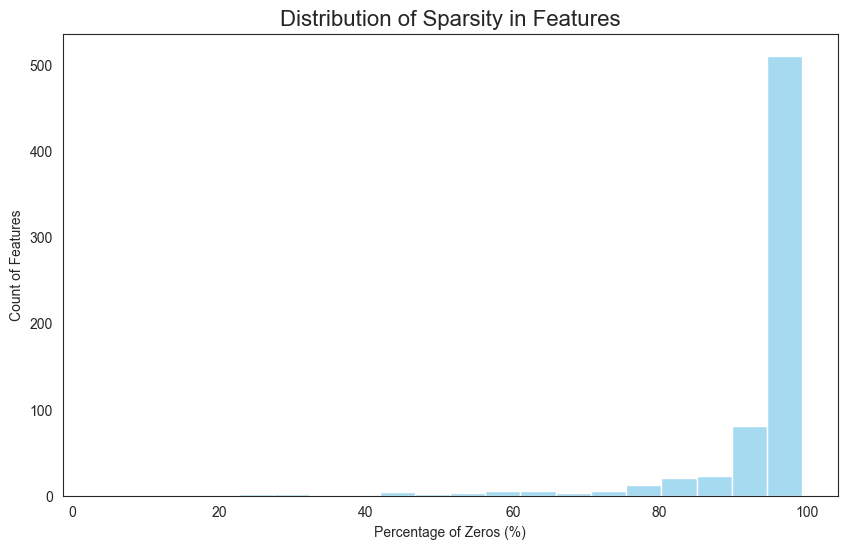


--- Target Distribution ---
Salmonella Typhimurium
1    87
0    84
Name: count, dtype: int64

--- Missing Values Check ---
No missing values found in the dataset.

--- Empty (Zero) Cells Check ---
Number of features with all zero values:
0

--- Missing Values in Target ---
No missing values found in the target variable.


In [218]:
# Data Overview
print("\n--- Data Overview ---")
print(df.info())  # Summary of data types and non-null values

# Sparsity Check
print("\n--- Sparsity Check ---")
sparsity = (X == 0).mean() * 100  # Percentage of zeros in each feature
print(sparsity.describe())  # Summary of sparsity across all features
plt.figure(figsize=(10, 6))
sns.histplot(sparsity, kde=False, bins=20, color='skyblue')
plt.title('Distribution of Sparsity in Features', fontsize=16)
plt.xlabel('Percentage of Zeros (%)')
plt.ylabel('Count of Features')
plt.show()

# Target Distribution
print("\n--- Target Distribution ---")
print(target.value_counts())  # Distribution of target classes


# Check for missing values (NaN)
print("\n--- Missing Values Check ---")
missing_values = df.isnull().sum()  # Count missing (NaN) values in each column
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
else:
    print(f"Columns with missing values:\n{missing_values[missing_values > 0]}")

# Check for empty cells
print("\n--- Empty (Zero) Cells Check ---")
empty_cells = (X == 0).sum()  # Count of zero cells in each feature
print(f"Number of features with all zero values:\n{(empty_cells == X.shape[0]).sum()}")  # Features with all zeros

# Check for missing values in the target variable
print("\n--- Missing Values in Target ---")
if target.isnull().sum() == 0:
    print("No missing values found in the target variable.")
else:
    print(f"Missing values in target: {target.isnull().sum()}")




# Remove Highly correlated features and overwrite X and feature_names

In [219]:
# Define the correlation threshold
correlation_threshold = 0.95 

import pandas as pd
import numpy as np

# X is a pandas DataFrame
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, columns=feature_names)

#Compute the pairwise correlation matrix (absolute values)
corr_matrix = X.corr().abs()

# Select the upper triangle of the correlation matrix without the diagonal
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Identify feature pairs with correlation above the threshold
features_to_remove = set()

for column in upper_triangle.columns:
    # Find features with correlation greater than the threshold
    high_corr_features = upper_triangle[column][upper_triangle[column] > correlation_threshold].index.tolist()
    features_to_remove.update(high_corr_features)

# Convert to a list
features_to_remove = list(features_to_remove)

# Remove the identified features from X and update feature_names
if features_to_remove:
    X.drop(columns=features_to_remove, inplace=True)
    feature_names = X.columns.tolist()  # Overwrite feature_names to match X
    print(f"Number of remaining features: {len(feature_names)}")
else:
    print(f"No features found with correlation greater than {correlation_threshold}. No features removed.")


Number of remaining features: 337


# Permutation Feature Importance

In [220]:

# Define the estimator with specified parameters
estimator = LogisticRegression(
    penalty='l1',
    solver='saga',
    C=1.75,
    max_iter=5000,
    random_state=111
)

# Fit the estimator
estimator.fit(X, y)

# Compute permutation feature importance
perm_importance = permutation_importance(
    estimator, X, y, n_repeats=100, random_state=111, scoring='roc_auc', n_jobs=-1
)

# Get feature names from X
feature_names = X.columns

# Create a DataFrame to hold permutation importance results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
})

# Sort features by importance
perm_importance_df = perm_importance_df.sort_values(by='Importance Mean', ascending=False)

print("\nPermutation Feature Importance:")
print(perm_importance_df)


Permutation Feature Importance:
      Feature  Importance Mean  Importance Std
63    Bit_549         0.088050        0.018289
223  Bit_1607         0.084801        0.019266
248  Bit_1754         0.019974        0.007741
312  Bit_1969         0.018628        0.007751
11     Bit_75         0.018393        0.005039
..        ...              ...             ...
115   Bit_934         0.000000        0.000000
114   Bit_932         0.000000        0.000000
155  Bit_1182        -0.000016        0.000138
96    Bit_807        -0.000099        0.001730
183  Bit_1366        -0.000112        0.000666

[337 rows x 3 columns]


# Remove Redundant Features and Overwrite X and feature_names

In [221]:
# Define the threshold for feature importance
importance_threshold = 0.01 

import pandas as pd

# Ensure 'feature_names' is defined
feature_names = X.columns.tolist()

# Identify features to remove based on the threshold
features_to_remove = perm_importance_df[
    perm_importance_df['Importance Mean'] < importance_threshold
]['Feature'].tolist()

print(f"\nNumber of features to remove: {len(features_to_remove)}")

# Ensure X is a DataFrame
if not isinstance(X, pd.DataFrame):
    X = pd.DataFrame(X, columns=feature_names)

# Remove the specified features from X
X = X.drop(columns=features_to_remove, errors='ignore') 

# Update 'feature_names' and 'feature_names_filtered' accordingly
feature_names = X.columns.tolist()
feature_names_filtered = feature_names

print(f"\nNumber of remaining features after removal: {X.shape[1]}")



Number of features to remove: 327

Number of remaining features after removal: 10


# Initialize estimator and Cross-Validation. Check model performance after feature removal

In [222]:

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import (
    make_scorer,
    confusion_matrix,
    matthews_corrcoef,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score
)

def specificity_score(y_true, y_pred):
    """
    Calculate specificity: TN / (TN + FP)
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if (tn + fp) == 0:
        return 0.0
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    """
    Calculate Negative Predictive Value (NPV): TN / (TN + FN)
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    if (tn + fn) == 0:
        return 0.0
    return tn / (tn + fn)

def mcc_score(y_true, y_pred):
    """
    Calculate Matthews Correlation Coefficient (MCC)
    """
    return matthews_corrcoef(y_true, y_pred)



# Define the scoring metrics dictionary, using make_scorer for custom scorers
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'roc_auc': 'roc_auc',
    'sensitivity': make_scorer(recall_score),  # Sensitivity is equivalent to recall
    'specificity': make_scorer(specificity_score),
    'precision': make_scorer(precision_score),
    'npv': make_scorer(npv_score),
    'mcc': make_scorer(mcc_score),
    'f1': make_scorer(f1_score)
}

# Set up repeated stratified k-fold cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100, random_state=111)

# Perform cross-validation on the training data
cv_results = cross_validate(
    estimator, X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=True
)

# Output cross-validation metrics
print("\nCross-validation metrics for Logistic Regression on training set:")
for scorer in scoring.keys():
    train_scores = cv_results['train_' + scorer]
    test_scores = cv_results['test_' + scorer]
    mean_train_score = np.mean(train_scores)
    std_train_score = np.std(train_scores)
    mean_test_score = np.mean(test_scores)
    std_test_score = np.std(test_scores)
    print(f"  {scorer}:")
    print(f"    Training: {mean_train_score:.4f} (+/- {std_train_score:.4f})")
    print(f"    Testing: {mean_test_score:.4f} (+/- {std_test_score:.4f})")



Cross-validation metrics for Logistic Regression on training set:
  accuracy:
    Training: 0.8433 (+/- 0.0146)
    Testing: 0.8123 (+/- 0.0624)
  roc_auc:
    Training: 0.9144 (+/- 0.0109)
    Testing: 0.8804 (+/- 0.0533)
  sensitivity:
    Training: 0.8672 (+/- 0.0309)
    Testing: 0.8284 (+/- 0.0948)
  specificity:
    Training: 0.8185 (+/- 0.0311)
    Testing: 0.7952 (+/- 0.0956)
  precision:
    Training: 0.8328 (+/- 0.0218)
    Testing: 0.8129 (+/- 0.0723)
  npv:
    Training: 0.8573 (+/- 0.0261)
    Testing: 0.8246 (+/- 0.0824)
  mcc:
    Training: 0.6879 (+/- 0.0292)
    Testing: 0.6305 (+/- 0.1247)
  f1:
    Training: 0.8490 (+/- 0.0148)
    Testing: 0.8167 (+/- 0.0636)


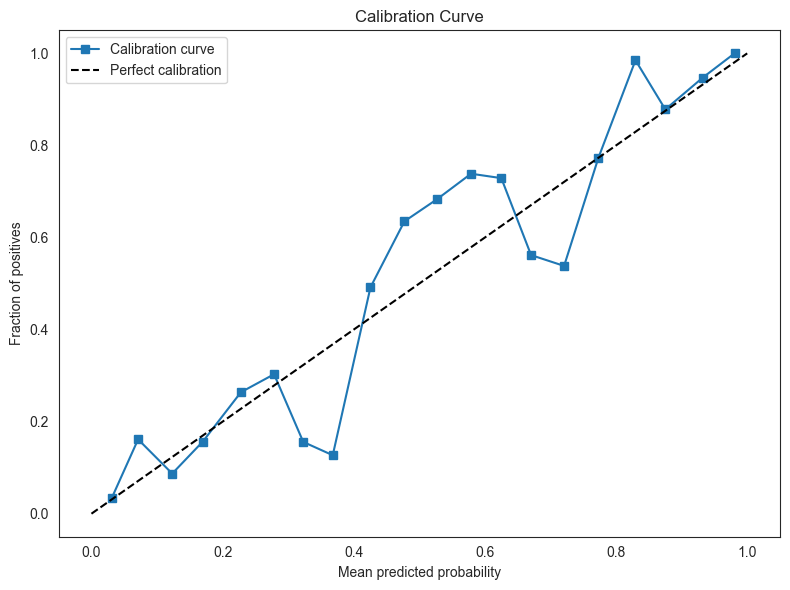

Calibration Slope: 1.0324
Calibration Intercept: -0.0041


In [242]:
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Convert X and y to numpy arrays (if they are pandas DataFrames/Series)
X_np = X.values if hasattr(X, 'values') else X
y_np = y.values if hasattr(y, 'values') else y

# Create a list to store probabilities and true values
y_probs = []
y_trues = []

# Initialize RepeatedStratifiedKFold with random_state for reproducibility
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100, random_state=111)

# Perform cross-validation and collect probabilities
for train_idx, test_idx in cv.split(X_np, y_np):
    estimator.fit(X_np[train_idx], y_np[train_idx])  # Fit the model on the training set
    y_prob_fold = estimator.predict_proba(X_np[test_idx])[:, 1]  # Get predicted probabilities for positive class
    y_true_fold = y_np[test_idx]  # Get true labels for the test set
    y_probs.extend(y_prob_fold)  # Store predicted probabilities
    y_trues.extend(y_true_fold)  # Store true labels

# Convert lists to numpy arrays for further processing
y_probs = np.array(y_probs)
y_trues = np.array(y_trues)

# Compute the calibration curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_trues, y_probs, n_bins=20)

# Fit a linear regression to estimate both the calibration intercept and slope
lin_reg = LinearRegression()
lin_reg.fit(mean_predicted_value.reshape(-1, 1), fraction_of_positives)
calibration_slope = lin_reg.coef_[0]
calibration_intercept = lin_reg.intercept_

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Calibration curve')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()

# Adjust the layout for better visualization
plt.tight_layout()

# Save and display the plot
plt.savefig('charts/calibration_curve.png')
plt.show()

# Output the calibration slope and intercept
print(f"Calibration Slope: {calibration_slope:.4f}")
print(f"Calibration Intercept: {calibration_intercept:.4f}")


# ROC AUC Precision Recall curves

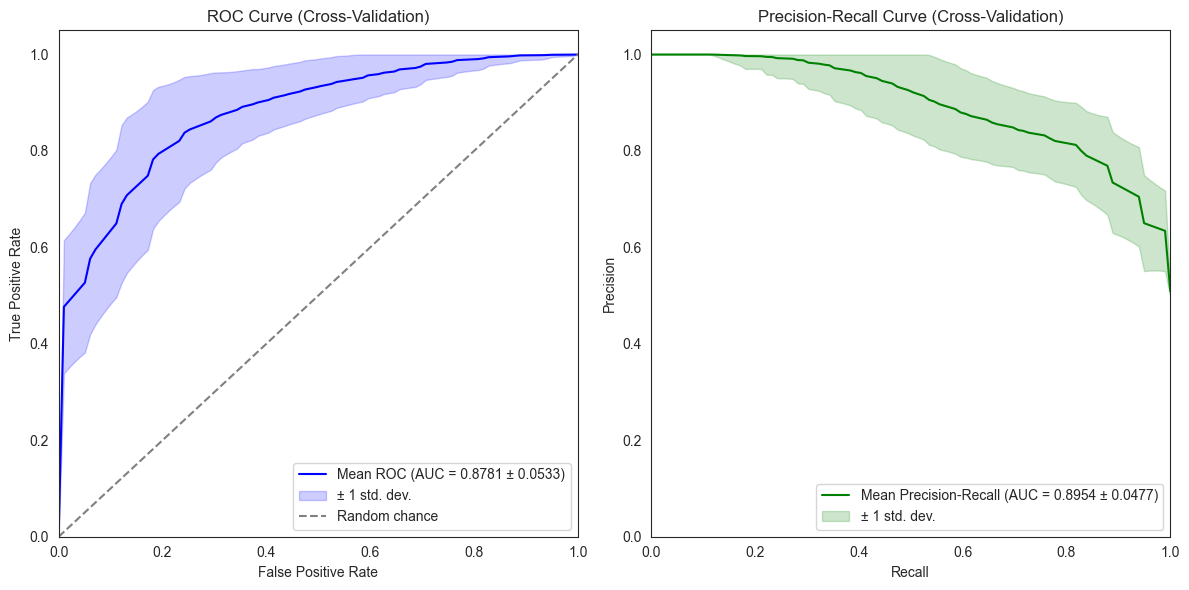

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve


# Set up the repeated stratified k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100, random_state=111)

# Initialize lists to store the metrics for plotting
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

precisions = []
aucs_pr = []
mean_recall = np.linspace(0, 1, 100)

# Start cross-validation
for train_idx, test_idx in cv.split(X, y):
    # Correctly assign training and testing data
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # Fit the model on the training data
    estimator.fit(X_train_cv, y_train_cv)

    # Predict probabilities on the test data
    y_proba_test = estimator.predict_proba(X_test_cv)[:, 1]

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test_cv, y_proba_test)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Interpolate TPR for consistent plotting
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0  # Ensure the start point is at zero
    tprs.append(interp_tpr)

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test_cv, y_proba_test)
    pr_auc = auc(recall, precision)
    aucs_pr.append(pr_auc)

    # Interpolate Precision for consistent plotting
    # Reverse recall and precision to ensure increasing order
    interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
    precisions.append(interp_precision)

# Plot ROC and Precision-Recall curves
plt.figure(figsize=(12, 6))

# Plot ROC Curve
plt.subplot(1, 2, 1)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the end point is at one
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})')
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='blue', alpha=0.2,
                 label='± 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Cross-Validation)')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
mean_precision = np.mean(precisions, axis=0)
mean_pr_auc = auc(mean_recall, mean_precision)
std_pr_auc = np.std(aucs_pr)

std_precision = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precision, 1)
precisions_lower = np.maximum(mean_precision - std_precision, 0)

plt.plot(mean_recall, mean_precision, color='green',
         label=f'Mean Precision-Recall (AUC = {mean_pr_auc:.4f} ± {std_pr_auc:.4f})')
plt.fill_between(mean_recall, precisions_lower, precisions_upper, color='green', alpha=0.2,
                 label='± 1 std. dev.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Cross-Validation)')
plt.legend(loc="lower right")

plt.tight_layout()

# Save and display the plot
plt.savefig('charts/roc_pr.png')
plt.show()



# Correlation Matrix

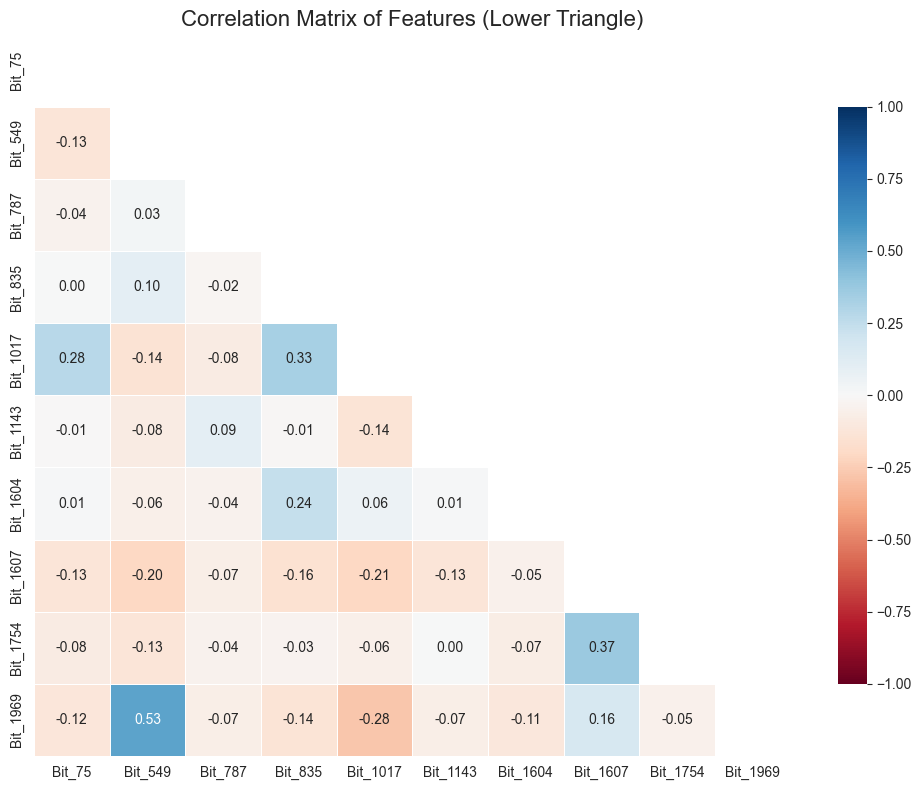

In [225]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert X to a DataFrame for easier handling
X_df = pd.DataFrame(X, columns=feature_names_filtered)

# Calculate the correlation matrix
corr_matrix = X_df.corr()

# Create a mask to display only the lower triangle (and hide the mirrored side)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Use the royal blue color scheme
cmap = sns.color_palette("RdBu", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    cmap=cmap, 
    annot=True, 
    fmt=".2f", 
    linewidths=0.5, 
    cbar_kws={"shrink": 0.8}, 
    vmin=-1, 
    vmax=1, 
    center=0
)

# Add title
plt.title('Correlation Matrix of Features (Lower Triangle)', fontsize=16)

# Adjust the layout for better visualization
plt.tight_layout()

# Save and display the plot
plt.savefig('charts/cm_log_reg.png')
plt.show()


# Partial Dependence Plots

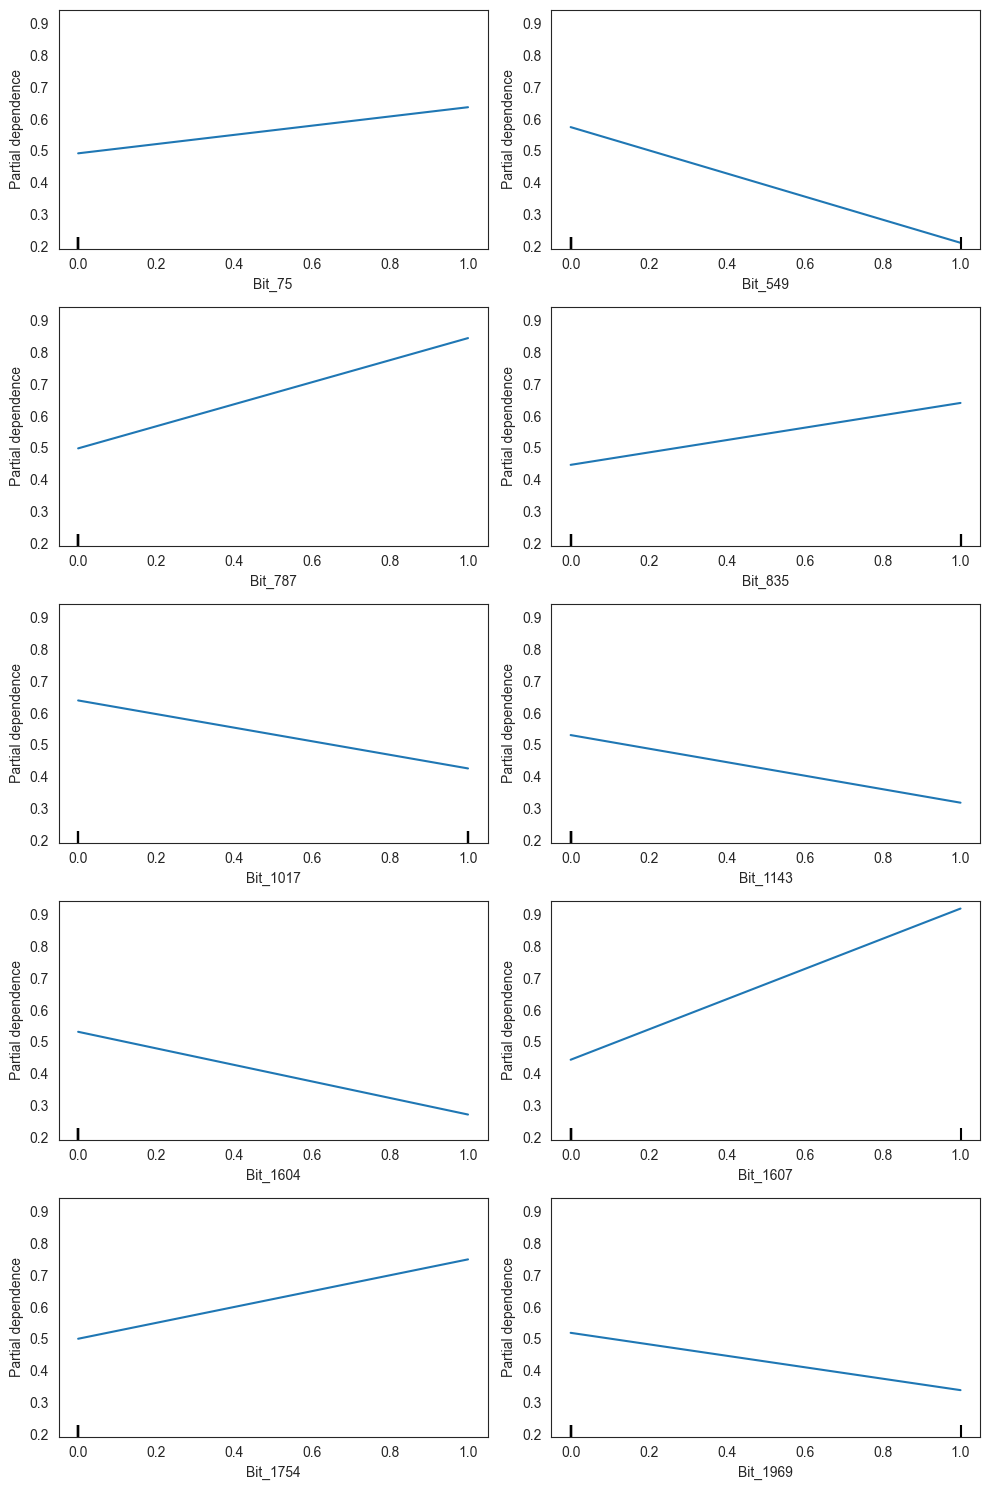

In [226]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression  


estimator.fit(X, y)  

# Generate the Partial Dependence Plots 
fig, ax = plt.subplots(5, 2, figsize=(10, 15))
pdp_disp = PartialDependenceDisplay.from_estimator(
    estimator,
    X,
    features=feature_names_filtered,
    ax=ax.ravel()[:10] 
)
 
plt.tight_layout()

# Save and display the plot
plt.savefig('charts/pdp_log_reg.png')
plt.show()


# Plot the mean and standard deviation of coefficients for evaluating feature importance

Coefficients with 95% Confidence Intervals (rounded to 2 decimals):
    Feature  Coefficient Mean  Lower CI  Upper CI
0  Bit_1607              3.85      2.93      4.76
1   Bit_549             -3.08     -4.84     -1.32
2   Bit_787              2.48     -0.09      5.05
3  Bit_1604             -2.14     -3.74     -0.54
4  Bit_1143             -1.69     -3.28     -0.10
5  Bit_1754              1.64      0.08      3.20
6  Bit_1017             -1.57     -2.53     -0.61
7   Bit_835              1.42      0.44      2.39
8  Bit_1969             -1.19     -2.57      0.20
9    Bit_75              1.06     -0.28      2.39


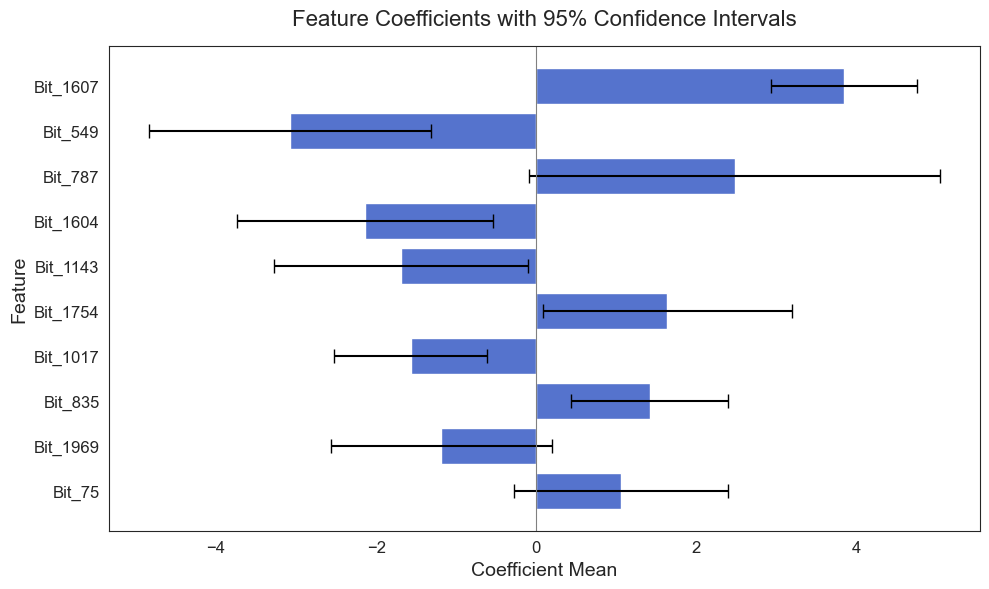

In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Step 2: Define Bootstrapping Parameters
# -----------------------------
n_iterations = 1000  # Number of bootstrap samples
coefficients_bootstrap = np.zeros((n_iterations, X.shape[1]))  # To store coefficients

# -----------------------------
# Step 3: Perform Bootstrapping
# -----------------------------
for i in range(n_iterations):
    # Resample the data with replacement
    X_resampled, y_resampled = resample(X, y, replace=True, random_state=i)
    
    # Fit the model on the resampled data
    estimator.fit(X_resampled, y_resampled)
    
    # Store the coefficients
    coefficients_bootstrap[i, :] = estimator.coef_[0]

# -----------------------------
# Step 4: Calculate Statistics
# -----------------------------
# Calculate the mean and standard deviation of coefficients
coef_mean = np.mean(coefficients_bootstrap, axis=0)
coef_std = np.std(coefficients_bootstrap, axis=0)

# Calculate 95% confidence intervals
lower_ci = coef_mean - 1.96 * coef_std
upper_ci = coef_mean + 1.96 * coef_std

# -----------------------------
# Step 5: Create a DataFrame for Visualization and Reporting
# -----------------------------
coef_bootstrap_df = pd.DataFrame({
    'Feature': feature_names_filtered,  # Updated feature names after removal
    'Coefficient Mean': np.round(coef_mean, 2),   # Rounded to two decimal places
    'Lower CI': np.round(lower_ci, 2),            # Rounded to two decimal places
    'Upper CI': np.round(upper_ci, 2)             # Rounded to two decimal places
})

# Sort the DataFrame by absolute mean coefficient for better visualization
coef_bootstrap_df['Absolute Mean Coefficient'] = coef_bootstrap_df['Coefficient Mean'].abs()
coef_bootstrap_df = coef_bootstrap_df.sort_values(by='Absolute Mean Coefficient', ascending=False).reset_index(drop=True)

# -----------------------------
# Output the coefficients in a format suitable for reporting
# -----------------------------
print("Coefficients with 95% Confidence Intervals (rounded to 2 decimals):")
print(coef_bootstrap_df[['Feature', 'Coefficient Mean', 'Lower CI', 'Upper CI']])

# Save the coefficients to a CSV file for later use in your report
coef_bootstrap_df[['Feature', 'Coefficient Mean', 'Lower CI', 'Upper CI']].to_csv('charts/coef_log_reg.csv', index=False)

# -----------------------------
# Step 6: Visualize Features with Confidence Intervals
# -----------------------------
plt.figure(figsize=(10, 6))
sns.set_style("white")

# Create the barplot without built-in confidence intervals
ax = sns.barplot(
    x='Coefficient Mean',
    y='Feature',
    data=coef_bootstrap_df,
    orient='h',
    color='royalblue',
    errorbar=None  # Use 'errorbar=None' to disable built-in confidence intervals
)

# Add custom error bars representing the 95% confidence intervals
for i, row in coef_bootstrap_df.iterrows():
    # Calculate the errors for lower and upper bounds
    lower_error = row['Coefficient Mean'] - row['Lower CI']
    upper_error = row['Upper CI'] - row['Coefficient Mean']
    
    # Add error bars
    ax.errorbar(
        x=row['Coefficient Mean'],
        y=i,  # Position of the bar on the y-axis
        xerr=np.array([[lower_error], [upper_error]]).reshape(2, 1),  # Correctly passing lower and upper errors
        fmt='none',
        ecolor='black',
        capsize=5
    )

# Enhance plot aesthetics
plt.title('Feature Coefficients with 95% Confidence Intervals', fontsize=16, pad=15)
plt.xlabel('Coefficient Mean', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='grey', linewidth=0.8)

# Adjust tick parameters for better readability
plt.tick_params(axis='both', which='major', labelsize=12)

# Adjust the layout for better visualization
plt.tight_layout()

# Save and display the plot
plt.savefig('charts/coef_log_reg.png')
plt.show()


Coefficients with 95% Confidence Intervals (rounded to 2 decimals):
                                             Feature  Coefficient Mean  \
0          hydroxyl group attached to a benzene ring              3.85   
1  branched alkyl side chain attached to a bicycl...             -3.08   
2                               part of a furan ring              2.48   
3         hydroxyl group bonded to a tertiary carbon             -2.14   
4                     portion of a hydrocarbon chain             -1.69   
5          propenyl group attached to a benzene ring              1.64   
6      an ethyl group attached to a cyclic structure             -1.57   
7  alken group attached to a benzene or cyclohexe...              1.42   
8                       part of a bicyclic structure             -1.19   
9                                      acetate group              1.06   

   Lower CI  Upper CI  
0      2.93      4.76  
1     -4.84     -1.32  
2     -0.09      5.05  
3     -3.74     -0.54

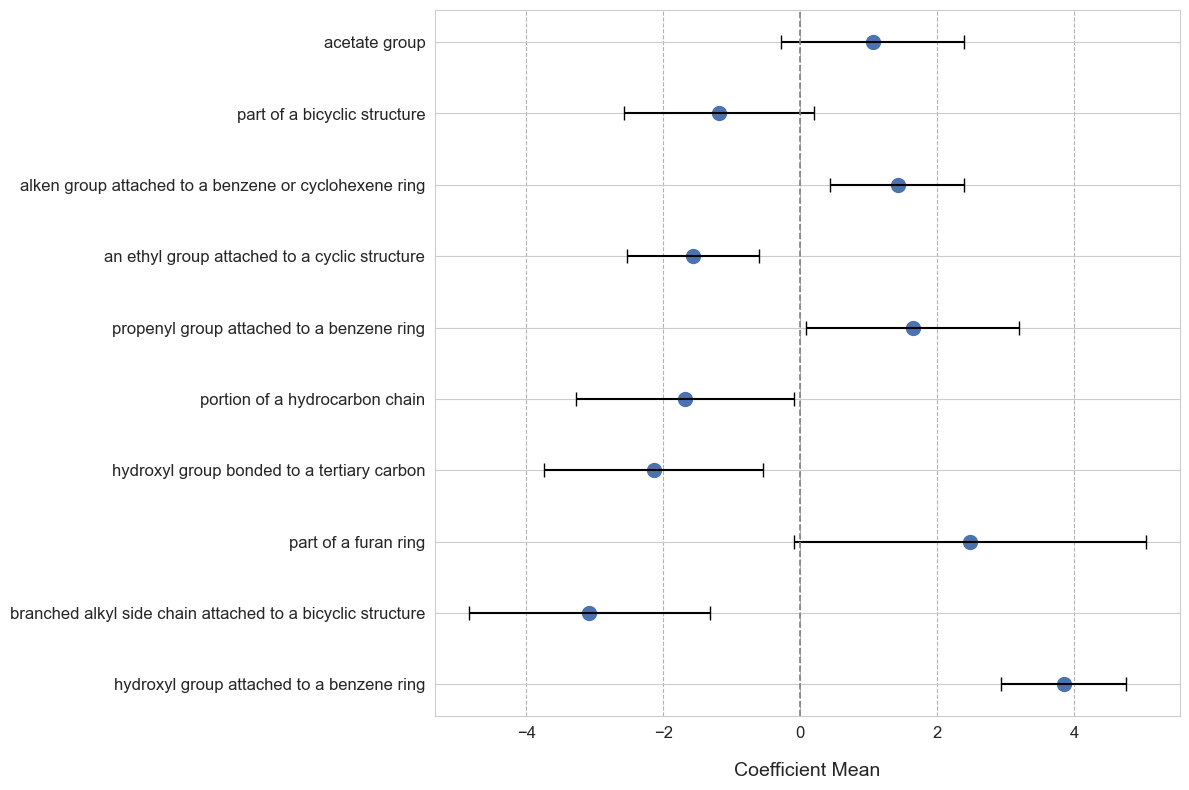

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

# -----------------------------
# Step 1: Create the dictionary to map bit numbers to fragment descriptions
# -----------------------------
bit_to_fragment = {
    'Bit_1607': 'hydroxyl group attached to a benzene ring',
    'Bit_549': 'branched alkyl side chain attached to a bicyclic structure',
    'Bit_787': 'part of a furan ring',
    'Bit_1604': 'hydroxyl group bonded to a tertiary carbon',
    'Bit_1143': 'portion of a hydrocarbon chain',
    'Bit_1754': 'propenyl group attached to a benzene ring',
    'Bit_1017': 'an ethyl group attached to a cyclic structure',
    'Bit_835': 'alken group attached to a benzene or cyclohexene ring',
    'Bit_1969': 'part of a bicyclic structure',
    'Bit_75': 'acetate group'
}


# Step 1: Modify the y-labels to split long labels into two lines
coef_bootstrap_df['Feature'] = coef_bootstrap_df['Feature'].apply(
    lambda x: '\n'.join(x.split(' ', 4))  # Split after the fourth word for multi-line labels
)
# -----------------------------
# Step 2: Define Bootstrapping Parameters
# -----------------------------
n_iterations = 1000  # Number of bootstrap samples
coefficients_bootstrap = np.zeros((n_iterations, X.shape[1]))  # To store coefficients

# -----------------------------
# Step 3: Perform Bootstrapping
# -----------------------------
for i in range(n_iterations):
    # Resample the data with replacement
    X_resampled, y_resampled = resample(X, y, replace=True, random_state=i)
    
    # Fit the model on the resampled data
    estimator.fit(X_resampled, y_resampled)
    
    # Store the coefficients
    coefficients_bootstrap[i, :] = estimator.coef_[0]

# -----------------------------
# Step 4: Calculate Statistics
# -----------------------------
# Calculate the mean and standard deviation of coefficients
coef_mean = np.mean(coefficients_bootstrap, axis=0)
coef_std = np.std(coefficients_bootstrap, axis=0)

# Calculate 95% confidence intervals
lower_ci = coef_mean - 1.96 * coef_std
upper_ci = coef_mean + 1.96 * coef_std

# -----------------------------
# Step 5: Create a DataFrame for Visualization and Reporting
# -----------------------------
coef_bootstrap_df = pd.DataFrame({
    'Feature': feature_names_filtered,  # Updated feature names after removal
    'Coefficient Mean': np.round(coef_mean, 2),   # Rounded to two decimal places
    'Lower CI': np.round(lower_ci, 2),            # Rounded to two decimal places
    'Upper CI': np.round(upper_ci, 2)             # Rounded to two decimal places
})

# Step 6: Replace the feature names in the DataFrame with the fragment descriptions
coef_bootstrap_df['Feature'] = coef_bootstrap_df['Feature'].replace(bit_to_fragment)

# Sort the DataFrame by absolute mean coefficient for better visualization
coef_bootstrap_df['Absolute Mean Coefficient'] = coef_bootstrap_df['Coefficient Mean'].abs()
coef_bootstrap_df = coef_bootstrap_df.sort_values(by='Absolute Mean Coefficient', ascending=False).reset_index(drop=True)

# -----------------------------
# Output the coefficients in a format suitable for reporting
# -----------------------------
print("Coefficients with 95% Confidence Intervals (rounded to 2 decimals):")
print(coef_bootstrap_df[['Feature', 'Coefficient Mean', 'Lower CI', 'Upper CI']])

# Save the coefficients to a CSV file for later use in your report
coef_bootstrap_df[['Feature', 'Coefficient Mean', 'Lower CI', 'Upper CI']].to_csv('charts/coef_log_reg_with_fragments.csv', index=False)

# -----------------------------
# Step 7: Visualize Features with a Dot Plot for Better Readability
# -----------------------------
plt.figure(figsize=(12, 8))  # Increase the figure size for better readability
sns.set_style("whitegrid")   # Use a white grid background for better visibility

# Create a dot plot (scatter plot) with error bars
plt.scatter(
    x='Coefficient Mean',
    y='Feature',
    data=coef_bootstrap_df,
    color='#4c72b0',
    s=100  # Increase the size of the dots for visibility
)

# Add custom error bars representing the 95% confidence intervals
for i, row in coef_bootstrap_df.iterrows():
    lower_error = row['Coefficient Mean'] - row['Lower CI']
    upper_error = row['Upper CI'] - row['Coefficient Mean']
    plt.errorbar(
        x=row['Coefficient Mean'],
        y=i,  # Position of the dot on the y-axis
        xerr=np.array([[lower_error], [upper_error]]).reshape(2, 1),
        fmt='none',
        ecolor='black',
        capsize=5,
        elinewidth=1.5  # Slightly thicker error bars
    )

# Enhance plot aesthetics
#plt.title(
#    'Feature Coefficients with 95% Confidence Intervals', 
#    fontsize=18, 
#    pad=20, 
#    weight='bold',
#    loc='center'  # This ensures the title is centered
#)
plt.xlabel('Coefficient Mean', fontsize=14, labelpad=15)
#plt.ylabel('Feature', fontsize=14, labelpad=15, weight='bold')

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='grey', linewidth=1.2, linestyle='--')

# Adjust tick parameters for better readability
plt.tick_params(axis='both', which='major', labelsize=12)

# Add gridlines for the x-axis
plt.grid(True, which='major', axis='x', linestyle='--', color='grey', alpha=0.6)

# Adjust the layout for better visualization
plt.tight_layout()

# Save and display the plot
plt.savefig('charts/coef_log_reg_dot_plot.png')
plt.show()

# Plot learning curves


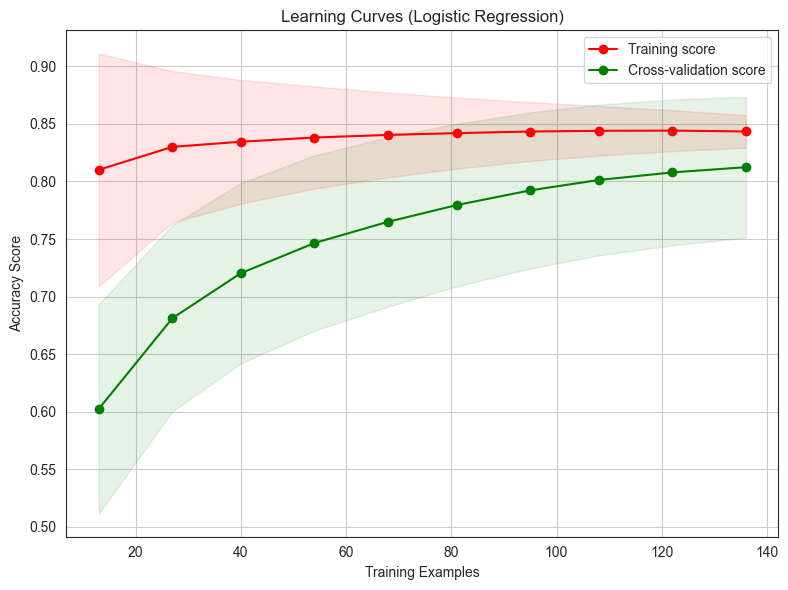

In [228]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, learning_curve


# Set up the repeated stratified k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1000, random_state=111)

# Generate learning curves using the defined cross-validation strategy
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, 
    cv=cv, 
    scoring='accuracy',          # You can change this to another metric if desired
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=111
)

# Calculate mean and standard deviation for training and testing scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std  = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.title('Learning Curves (Logistic Regression)')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
# Adjust the layout for better visualization
plt.tight_layout()

# Save and display the plot
plt.savefig('charts/learning_curve_log_reg.png')
plt.show()


# Inspecting features

In [104]:
# 'X' is your feature matrix and we assume it has the feature names as its columns

import numpy as np
import pandas as pd
import os

# Get the feature names from the dataset (or X dataframe)
feature_names = X.columns

# Extract non-zero coefficient indices from the trained logistic regression model
important_feature_indices = np.where(estimator.coef_[0] != 0)[0]

# Get the corresponding feature names for the non-zero coefficients
important_features = feature_names[important_feature_indices].tolist()

# Print the important features in the required format (optional)
print("Important features extracted from the model:")
print("important_features = [")
for feature in important_features:
    print(f"    '{feature}',")
print("]")


Important features extracted from the model:
important_features = [
    'Bit_75',
    'Bit_549',
    'Bit_787',
    'Bit_835',
    'Bit_1017',
    'Bit_1143',
    'Bit_1604',
    'Bit_1607',
    'Bit_1754',
    'Bit_1969',
]


In [105]:
# Load the data
file_path = 'aggregated_plants.csv'
df = pd.read_csv(file_path)

# Use the dynamically extracted list of important features
# 'important_features' is now coming from the previous cell's output
save_dir = './features/'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Iterating through each important feature
for feature in important_features:
    # Filter rows where the feature is present (1)
    feature_present_df = df[df[feature] == 1]
    
    # Drop all other 'Bit_' columns except the one in focus
    columns_to_drop = [col for col in df.columns if col.startswith('Bit_') and col != feature]
    feature_present_df = feature_present_df.drop(columns=columns_to_drop)
    
    # Define the new file path
    new_file_path = os.path.join(save_dir, f"{feature}.csv")
    
    # Save the filtered rows to a new CSV file
    feature_present_df.to_csv(new_file_path, index=False)
    
    print(f"Rows where {feature} is present and all other Bit_ columns are removed have been saved to '{new_file_path}'")


Rows where Bit_75 is present and all other Bit_ columns are removed have been saved to './features/Bit_75.csv'
Rows where Bit_549 is present and all other Bit_ columns are removed have been saved to './features/Bit_549.csv'
Rows where Bit_787 is present and all other Bit_ columns are removed have been saved to './features/Bit_787.csv'
Rows where Bit_835 is present and all other Bit_ columns are removed have been saved to './features/Bit_835.csv'
Rows where Bit_1017 is present and all other Bit_ columns are removed have been saved to './features/Bit_1017.csv'
Rows where Bit_1143 is present and all other Bit_ columns are removed have been saved to './features/Bit_1143.csv'
Rows where Bit_1604 is present and all other Bit_ columns are removed have been saved to './features/Bit_1604.csv'
Rows where Bit_1607 is present and all other Bit_ columns are removed have been saved to './features/Bit_1607.csv'
Rows where Bit_1754 is present and all other Bit_ columns are removed have been saved to '

# Adding SMILE strings to the feautes dataframe 

In [106]:
import pandas as pd
import os
import ast
from collections import Counter
import glob

def safe_literal_eval(s):
    dict_strings = [d.strip() for d in s.split(';') if d.strip()]
    all_dicts = {}
    for dict_str in dict_strings:
        try:
            all_dicts.update(ast.literal_eval(dict_str))
        except Exception as e:
            print(f"Failed to parse part: {dict_str}\nError: {e}")
    return all_dicts

def preprocess_bit_name(bit_name):
    bit_number = bit_name.replace('Bit_', '').replace('.csv', '')
    return int(bit_number)

features_dir = 'features/'
reorganized_plants_path = 'reorganized_plants_filtered.csv'
combined_chemicals_path = '../initial_data/matched_chemicals_final_manual.csv'

reorganized_plants_df = pd.read_csv(reorganized_plants_path)
combined_chemicals_df = pd.read_csv(combined_chemicals_path)  # Load the combined chemicals data
reorganized_plants_df = reorganized_plants_df.drop_duplicates(subset=['Plant_Species', 'Chemical'])

assert 'Concentration' in reorganized_plants_df.columns, "Concentration column not found in the reorganized plants data!"

bit_files = glob.glob(os.path.join(features_dir, 'Bit_*.csv'))

for bit_file in bit_files:
    bit_name = os.path.basename(bit_file)
    bit_name = bit_name.replace('.csv', '')

    new_bit_file = os.path.join(features_dir, f"{bit_name}_updated.csv")

    bit_df = pd.read_csv(bit_file)

    bit_df['BitInterpretations'] = bit_df['BitInterpretations'].apply(safe_literal_eval)

    if 'SMILES' not in bit_df.columns:
        bit_df.insert(3, 'SMILES', '')
    if 'Chemical' not in bit_df.columns:
        bit_df.insert(4, 'Chemical', '')
    if 'Chemical_name' not in bit_df.columns:  # Add Chemical_name column 
        bit_df.insert(5, 'Chemical_name', '')

    expanded_rows = []

    for index, row in bit_df.iterrows():
        plant_species = row['Plant_Species']
        bit_interpretations = row['BitInterpretations']
        bit_number = preprocess_bit_name(bit_name)

        if bit_number in bit_interpretations:
            interpreted_bit = str(bit_interpretations[bit_number])
        else:
            interpreted_bit = ''

        matching_rows = reorganized_plants_df[
            (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower()) &
            (reorganized_plants_df[bit_name] == 1)]

        for _, match in matching_rows.iterrows():
            new_row = row.copy()
            new_row['SMILES'] = match['SMILES']
            new_row['Chemical'] = match['Chemical']
            new_row['BitInterpretations'] = interpreted_bit
            new_row['Chemical_name'] = combined_chemicals_df[combined_chemicals_df['SMILES'] == match['SMILES']]['Chemical Name'].iloc[0]

            # Ensure matching both 'SMILES' and 'Plant_Species'
            concentration_match = reorganized_plants_df[
                (reorganized_plants_df['SMILES'] == match['SMILES']) & 
                (reorganized_plants_df['Plant_Species'].str.lower() == plant_species.lower())
            ]['Concentration']

            new_row['Concentration'] = concentration_match.iloc[0] if not concentration_match.empty else None

            expanded_rows.append(new_row)

    expanded_bit_df = pd.DataFrame(expanded_rows)

    # Remove the 'Chemical' column as it's no longer needed
    expanded_bit_df = expanded_bit_df.drop(columns=['Chemical'])

    expanded_bit_df = expanded_bit_df.sort_values(by='Chemical_name', ascending=True)

    expanded_bit_df.to_csv(new_bit_file, index=False)

    print(f"Updated {bit_name} with individual SMILES, Chemical names from combined file has been saved to {new_bit_file}")

print("All Bit files have been processed and updated with individual SMILES-Chemical pairs, Chemical names, and Concentrations.")


Updated Bit_787 with individual SMILES, Chemical names from combined file has been saved to features/Bit_787_updated.csv
Updated Bit_1969 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1969_updated.csv
Updated Bit_1607 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1607_updated.csv
Updated Bit_1017 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1017_updated.csv
Updated Bit_1604 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1604_updated.csv
Updated Bit_1754 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1754_updated.csv
Updated Bit_75 with individual SMILES, Chemical names from combined file has been saved to features/Bit_75_updated.csv
Updated Bit_1143 with individual SMILES, Chemical names from combined file has been saved to features/Bit_1143_updated.csv
Updated Bit_835 with i

# Remove all rare chemicals which appear only once (not interesting for the domain)

In [107]:
import pandas as pd
import os
import glob

features_dir = 'features/'

# Gather all updated CSV files
updated_files = glob.glob(os.path.join(features_dir, '*_updated.csv'))

# Process each CSV file independently
for file in updated_files:
    df = pd.read_csv(file)
    # Count the occurrences of each chemical name in this specific file
    chemical_name_counts = df['Chemical_name'].value_counts()
    # Identify chemical names that appear more than once
    chemicals_to_keep = chemical_name_counts[chemical_name_counts > 1].index
    
    # Filter the dataframe to only include rows with chemical names that appear more than once
    filtered_df = df[df['Chemical_name'].isin(chemicals_to_keep)]
    
    # Save the filtered dataframe back to the same CSV file
    filtered_df.to_csv(file, index=False)
    print(f"Filtered data saved back to {file}")

print("All updated CSV files have been re-processed to exclude unique chemical names.")


Filtered data saved back to features/Bit_75_updated.csv
Filtered data saved back to features/Bit_1969_updated.csv
Filtered data saved back to features/Bit_1143_updated.csv
Filtered data saved back to features/Bit_1604_updated.csv
Filtered data saved back to features/Bit_1754_updated.csv
Filtered data saved back to features/Bit_1607_updated.csv
Filtered data saved back to features/Bit_549_updated.csv
Filtered data saved back to features/Bit_1017_updated.csv
Filtered data saved back to features/Bit_835_updated.csv
Filtered data saved back to features/Bit_787_updated.csv
All updated CSV files have been re-processed to exclude unique chemical names.


# Visualisation of molecular features

In [112]:
from rdkit.Chem import rdMolDescriptors, Draw
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator, AdditionalOutput
import pandas as pd
import os

# Use the dynamically extracted list of important features from the previous step
# 'important_features' is now coming from the previous cell's output

# Define the output folder for SVG images
output_folder = 'visualizations'  # Adjust as needed
os.makedirs(output_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Create a Morgan generator
morgan_gen = GetMorganGenerator(radius=2, fpSize=2048)  # Equivalent parameters to your original function

for feature in important_features:
    bit_number = feature.split('_')[1]  # Extract the bit number from the feature name
    updated_file_path = f'features/{feature}_updated.csv'  # Construct the file path dynamically
    
    try:
        df = pd.read_csv(updated_file_path)
    except FileNotFoundError:
        print(f"File {updated_file_path} not found, skipping.")
        continue

    bit_to_visualize = int(bit_number)  # Convert the bit number to an integer

    for idx, row in df.drop_duplicates(subset='SMILES').iterrows():
        smiles = row['SMILES']
        chemical_name = row.get('Chemical_name', 'Unnamed_Chemical')  # Default name if not present
        plant_species = row.get('Plant_Species', 'UnknownSpecies').split()[:2]  # Get first two words of plant species
        concentration = row.get('Concentration', 0)  # Get concentration value, default to 0 if not present

        # Generate a molecule from the SMILES string
        mol = Chem.MolFromSmiles(smiles)
        if not mol: continue  # Skip if molecule can't be created

        # Initialize AdditionalOutput to collect bit info
        additional_output = AdditionalOutput()
        additional_output.AllocateBitInfoMap()  # Toggle bit information collection

        # Generate a Morgan fingerprint with additional output (bitInfo)
        fp = morgan_gen.GetFingerprint(mol, additionalOutput=additional_output)

        # Extract bit information
        bit_info = additional_output.GetBitInfoMap()

        if bit_to_visualize in bit_info:
            # Visualize the first example of the bit setting
            whichExample = 0  # Always use the first example
            img = Draw.DrawMorganBit(mol, bit_to_visualize, bit_info, whichExample=whichExample, useSVG=True)
            
            # Ensure the chemical name, plant species, and concentration are filesystem safe
            safe_chemical_name = ''.join(e for e in chemical_name if e.isalnum())
            safe_plant_species = '_'.join(''.join(e for e in word if e.isalnum()) for word in plant_species)
            safe_concentration = ''.join(e for e in str(concentration) if e.isdigit() or e == '.')  # Convert float to string

            # Filename includes the bit, chemical name, plant species, and concentration
            svg_file_path = os.path.join(output_folder, f"bit_{bit_to_visualize}_{safe_chemical_name}_{safe_plant_species}_conc_{safe_concentration}.svg")
            with open(svg_file_path, "w") as svg_file:
                svg_file.write(img.data)
            print(f"Saved SVG image to {svg_file_path}")


Saved SVG image to visualizations/bit_75_Linalylacetate_Aeollanthus_suaveolens_conc_0.1583.svg
Saved SVG image to visualizations/bit_75_alphaTerpinylacetate_Elletaria_cardamomum_conc_0.3931.svg
Saved SVG image to visualizations/bit_549_Bicyclogermacrene_Neolitsea_brassii_conc_0.126.svg
Saved SVG image to visualizations/bit_549_alphaPinene_Cupressocyparis_leylandii_conc_0.1.svg
Saved SVG image to visualizations/bit_549_betaPinene_Piper_nigrum_conc_0.0963.svg
Saved SVG image to visualizations/bit_549_delta3Carene_Pinus_mugo_conc_0.162.svg
Saved SVG image to visualizations/bit_787_Furfural_Averrhoa_bilimbi_conc_0.191.svg
Saved SVG image to visualizations/bit_835_EAnethole_Foeniculum_vulgare_conc_0.7604.svg
Saved SVG image to visualizations/bit_835_Bicyclogermacrene_Neolitsea_brassii_conc_0.126.svg
Saved SVG image to visualizations/bit_835_Ethylcinnamate_Elaeagnus_angustifolia_conc_0.3279.svg
Saved SVG image to visualizations/bit_835_GermacreneD_Lonicera_japonica_conc_0.28.svg
Saved SVG im

# *For the report get the unique names of the chemicals containing the feature

In [236]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('features/Bit_1969_updated.csv')

# Convert all names in 'Chemical name' to lowercase
lowercase_names = df['Chemical_name'].str.lower()

# Get unique names
unique_names = lowercase_names.unique()

# Join the unique names into a comma-separated string
names_string = ', '.join(unique_names)

# Print the result
print(names_string)


alpha-pinene, gamma-terpinene


In [232]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('features/Bit_75_updated.csv')

# Convert all names in 'Chemical name' to lowercase
lowercase_names = df['Chemical_name'].str.lower()

# Get unique names
unique_names = lowercase_names.unique()

# Join the unique names into a comma-separated string
names_string = ', '.join(unique_names)

# Print the result
print(names_string)


linalyl acetate, alpha-terpinyl acetate


# SVG to PNG

In [115]:
import subprocess
import os

# Define the source and target directories
source_dir = "visualizations"
target_dir = source_dir  

# List all SVG files in the source directory
svg_files = [f for f in os.listdir(source_dir) if f.endswith('.svg')]

# Convert each SVG file to PNG using Inkscape
for svg_file in svg_files:
    source_path = os.path.join(source_dir, svg_file)
    target_path = os.path.join(target_dir, svg_file.replace('.svg', '.png'))
    
    # Construct the Inkscape command for conversion
    # Adding --export-dpi=300 for the DPI setting
    # Inkscape 1.0 and later versions handle transparency by default for PNG exports
    command = [
        '/Applications/Inkscape.app/Contents/MacOS/inkscape', 
        source_path, 
        '--export-dpi=300', 
        '--export-type=png', 
        '--export-filename', 
        target_path
    ]
    
    # Execute the command
    subprocess.run(command)

print("Conversion complete.")




Conversion complete.
